In [1]:
import io
import csv
import numpy as np
import tensorflow as tf
from random import randint
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numpy import array, argmax, array_equal 
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU, Dense, Flatten, TimeDistributed, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from matplotlib.font_manager import FontProperties
from tensorflow.keras.optimizers import Adam
tf.keras.backend.set_floatx('float64')

In [2]:
!yes | wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2022-05-08 16:12:19--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   141MB/s    in 12s     

2022-05-08 16:12:31 (161 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [3]:
!yes | tar xopf dakshina_dataset_v1.0.tar

In [4]:
hindi_font = FontProperties(fname = 'nirmala.ttf') 

In [5]:
train_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
dev_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

In [6]:
# reads text document and returns a list of lists comprising the romanized and native versions of the words
def read(f):
    hindi = []
    latin = []
    with io.open(f, encoding ='utf-8') as f:
        for line in f:
            if '\t' not in line:
                continue
            tokens = line.rstrip().split("\t")
            latin.append(tokens[1])
            hindi.append(tokens[0])
    return latin, hindi

In [7]:
tr_src, tr_tar = read(train_dir)
val_src, val_tar = read(dev_dir)
tst_src, tst_tar = read(test_dir)

In [8]:
A = np.arange(len(tr_src))
np.random.shuffle(A)
A1 = np.arange(len(val_src))
np.random.shuffle(A1)

In [9]:
char_inp = set()
char_tar = set()
ns_txt_inp = []
ns_txt_tar = []
ns_txt_inp_val = []
ns_txt_tar_val = []

In [10]:
for (txt_inp, txt_tar) in zip(tr_src, tr_tar):
    # tab : "start sequence" character
    # \n  : "end sequence" character
    txt_tar = "B" + txt_tar + "E"
    ns_txt_inp.append(txt_inp)
    ns_txt_tar.append(txt_tar)

    for char in txt_inp:
        if char not in char_inp:
            char_inp.add(char)

    for char in txt_tar:
        if char not in char_tar:
            char_tar.add(char)

In [11]:
for (txt_inp, txt_tar) in zip(val_src, val_tar):
    # tab : "start sequence" character
    # \n  : "end sequence" character
    txt_tar = "B" + txt_tar + "E"
    ns_txt_inp_val.append(txt_inp)
    ns_txt_tar_val.append(txt_tar)
    for char in txt_inp:
        if char not in char_inp:
            char_inp.add(char)
    for char in txt_tar:
        if char not in char_tar:
            char_tar.add(char)

In [12]:
inps_txt = []
tars_txt = []

for i in range(len(tr_src)):
    inps_txt.append(ns_txt_inp[A[i]])
    tars_txt.append(ns_txt_tar[A[i]])

In [13]:
txt_inp_vals = []
txt_tar_vals = []

for i in range(len(val_src)):
    txt_inp_vals.append(ns_txt_inp_val[A1[i]])
    txt_tar_vals.append(ns_txt_tar_val[A1[i]])

In [14]:
char_inp.add(" ")
char_tar.add(" ")

In [15]:
char_inp = sorted(list(char_inp))
char_tar = sorted(list(char_tar))

In [16]:
enc_tok_num = len(char_inp)
dec_tok_num= len(char_tar)

In [17]:
len_max_enc = max([len(txt) for txt in inps_txt])
len_max_dec = max([len(txt) for txt in tars_txt])
len_max_enc_val = max([len(txt) for txt in txt_inp_vals])
len_max_dec_val = max([len(txt) for txt in txt_tar_vals])

In [18]:
tok_ind_inp= dict([(j, k) for k, j in enumerate(char_inp)])
tok_ind_tar= dict([(j, k) for k, j in enumerate(char_tar)])

In [19]:
rsci = dict((i, char) for char, i in tok_ind_inp.items())
rtci = dict((i, char) for char, i in tok_ind_tar.items())

In [20]:
inp_txt_trnc = inps_txt[:44160]
tar_txt_trnc = tars_txt[:44160]

In [21]:
enc_inp = np.zeros(
    (len(inp_txt_trnc), len_max_enc, enc_tok_num), dtype="float64"
)
dec_tar = np.zeros(
    (len(inp_txt_trnc), len_max_dec, dec_tok_num), dtype="float64"
)

In [22]:
for i, (txt_inp, txt_tar) in enumerate(zip(inp_txt_trnc, tar_txt_trnc)):
    for m, n in enumerate(txt_inp):
        enc_inp[i, m, tok_ind_inp[n]] = 1.0
    enc_inp[i, m + 1 :, tok_ind_inp[" "]] = 1.0
    for m, n in enumerate(txt_tar):
        dec_tar[i, m, tok_ind_tar[n]] = 1.0
    dec_tar[i, m + 1 :, tok_ind_tar[" "]] = 1.0

In [23]:
inp_val_enc_dt = np.zeros(
    (len(txt_inp_vals), len_max_enc, enc_tok_num), dtype="float64"
)
tar_val_dec_dt = np.zeros(
    (len(txt_tar_vals), len_max_dec, dec_tok_num), dtype="float64"
)

In [24]:
for i, (txt_inp, txt_tar) in enumerate(zip(txt_inp_vals, txt_tar_vals)):
    
    for t, n in enumerate(txt_inp):
        inp_val_enc_dt[i, t, tok_ind_inp[n]] = 1.0
    inp_val_enc_dt[i, t + 1 :, tok_ind_inp[" "]] = 1.0

    for t, n in enumerate(txt_tar):
        tar_val_dec_dt[i, t, tok_ind_tar[n]] = 1.0
    tar_val_dec_dt[i, t + 1: , tok_ind_tar[" "]] = 1.0

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
  
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, query, values):
    
    qt = tf.expand_dims(query, 1)
    
    sc = self.V(tf.nn.tanh(
        self.W1(qt) + self.W2(values)))
    
    attn_wgt = tf.nn.softmax(sc, axis=1)
    vec_cxt = attn_wgt * values
    vec_cxt = tf.reduce_sum(vec_cxt, axis=1)

    return vec_cxt, attn_wgt

In [28]:
class model_with_attention(object):

  def __init__(self, Type = 'RNN', hid_layer_size=32, l_r= 1e-3, drop_prob = 0.3, number_of_epochs = 10, batch_size = 32, attn = 'bahdanau'):
    
    self.Type = Type
    self.hid_layer_size = hid_layer_size
    self.l_r = l_r
    self.drop_prob = drop_prob
    self.number_of_epochs = number_of_epochs
    self.batch_size = batch_size
    self.attn = attn

  def fit(self, enc_inp, dec_tar):

    enc_inps = Input(shape=(len_max_enc, enc_tok_num), name='encoder_inputs')

    if self.Type == 'LSTM':

      enc_LSTM = LSTM(self.hid_layer_size,return_sequences=True, return_state=True, dropout = self.drop_prob, name='encoder_lstm')
      enc_outs, hs, cs = enc_LSTM(enc_inps)
      states_enc = [hs, cs]

    elif self.Type == 'GRU':

      enc_GRU = GRU(self.hid_layer_size,return_sequences=True, return_state=True, dropout = self.drop_prob, name='encoder_gru')
      enc_outs, hs = enc_GRU(enc_inps)
      states_enc = [hs]

    elif self.Type == 'RNN':

      enc_rnn = SimpleRNN(self.hid_layer_size,return_sequences=True, return_state=True, dropout = self.drop_prob, name='encoder_rnn')
      enc_outs, hs = enc_rnn(enc_inps)
      states_enc = [hs]

    # Attention Layer
    if self.attn == 'bahdanau':
      attn= BahdanauAttention(self.hid_layer_size)

    # Decoder Layers
    inps_deco = Input(shape=(1, (dec_tok_num + self.hid_layer_size)),name='decoder_inputs')

    if self.Type == 'LSTM':

      dec_LSTM = LSTM(self.hid_layer_size, dropout = self.drop_prob, return_state=True, name='decoder_lstm')
    
    elif self.Type == 'GRU':

      dec_GRU = GRU(self.hid_layer_size, dropout = self.drop_prob, return_state=True, name='decoder_gru')
    
    elif self.Type == 'RNN':

      dec_RNN = SimpleRNN(self.hid_layer_size, dropout = self.drop_prob, return_state=True, name='decoder_rnn')  
    
    
    dec_den = Dense(dec_tok_num, activation='softmax',  name='decoder_dense')
    oa = []

    ip = np.zeros((self.batch_size, 1, dec_tok_num))
    ip[:, 0, 0] = 1 

    dec_outs = hs
    states = states_enc

    for _ in range(len_max_dec):

      vec_cxt, attn_wgt = attn(dec_outs, enc_outs)
      vec_cxt = tf.expand_dims(vec_cxt, 1)
      
      ip = tf.concat([vec_cxt, ip], axis=-1)

      if self.Type == 'LSTM':

        dec_outs, h, c = dec_LSTM(ip, initial_state=states)

      if self.Type == 'GRU':

        dec_outs, h = dec_GRU(ip, initial_state=states)

      if self.Type == 'RNN':

        dec_outs, h = dec_RNN(ip, initial_state=states)
      
      op = dec_den(dec_outs)
      op = tf.expand_dims(op, 1)
      oa.append(op)
      ip = op
      if self.Type == 'LSTM':

        states = [h, c]

      if self.Type == 'GRU' or self.Type == 'RNN':
        
        states = [h]


    dec_outs = Lambda(lambda x: K.concatenate(x, axis=1))(oa)
    model = Model(enc_inps, dec_outs, name='model_encoder_decoder')
    
    optimizer = Adam(lr=self.l_r, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(enc_inp, dec_tar,
              batch_size=self.batch_size, 
              epochs=self.number_of_epochs,
              #callbacks = [WandbCallback()]
              )
    
    if self.Type == 'LSTM':

        return enc_LSTM, attn, dec_LSTM, dec_den

    if self.Type == 'GRU':
        
        return enc_GRU,attn, dec_GRU, dec_den
    
    if self.Type == 'RNN':
        
        return enc_rnn,attn, dec_RNN, dec_den 


  def evaluate(self,si):

      attn_plot = np.zeros((len_max_dec, len_max_enc))
      sequence = si
      enc_inps = array(sequence).reshape(1,len_max_enc, enc_tok_num)

      enc_inps = tf.convert_to_tensor(enc_inps,dtype=tf.float32)

      if self.Type == 'LSTM':

          enc_outs, hs, cs = encoder(enc_inps)
          states_enc = [hs, cs]

      elif self.Type == 'GRU':

          enc_outs, hs = encoder(enc_inps)
          states_enc = [hs]

      elif self.Type == 'RNN':

          enc_outs, hs = encoder(enc_inps)
          states_enc = [hs]

      oa = []

      dec_inp = np.zeros((1, 1, dec_tok_num))
      dec_inp[:, 0, 0] = 1 

      inputs = dec_inp
      dec_outs = hs
      states = states_enc

      w_a =[]

      for t in range(len_max_dec):

          vec_cxt, a_w = attn(dec_outs, enc_outs)

          a_w = tf.reshape(a_w, (-1, ))
          w_a.append(a_w)

          attn_plot[t] = a_w.numpy()

          dec_outs=tf.expand_dims(dec_outs, 1)

          vec_cxt = tf.expand_dims(vec_cxt, 1)
          inputs = tf.concat([vec_cxt, inputs], axis=-1)

          if self.Type == 'LSTM':

              dec_outs, state_h, state_c = decoder(inputs, initial_state=states)
          
          if self.Type == 'GRU':
          
              dec_outs, state_h = decoder(inputs, initial_state=states)
          
          if self.Type == 'RNN':
          
              dec_outs, state_h = decoder(inputs, initial_state=states)

          outputs = dec_den(dec_outs) 
          outputs = tf.expand_dims(outputs, 1)
          oa.append(outputs)
          inputs = outputs

          if self.Type == 'LSTM':
              
              states = [state_h, state_c]
          
          if self.Type == 'GRU' or self.Type == 'RNN':
              
              states = [state_h]

      dec_outs = Lambda(lambda x: K.concatenate(x, axis=1))(oa)
      seq_outs = dec_outs[0]
      seq_out = tf.argmax(seq_outs, axis=1)
      seq_out = seq_out.numpy()
      si = tf.argmax(si, axis = 1)
      si = si.numpy()
      list(filter(lambda num: num != 0, si))
      list(filter(lambda num: num != 0, seq_out))

      return si, seq_out, attn_plot, w_a

  def plot_attention(self,attention, sequence, predicted_sequence, idx,fig):

      ax = fig.add_subplot(4, 3, idx)
      ax.matshow(attention, cmap='viridis')

      fontdict = {'fontsize': 16}
      seq = ''
      for i in range(len(sequence)):
          seq = seq + rsci[sequence[i]]

      pred = ''
      for i in range(len(predicted_sequence)):
          pred = pred + rtci[predicted_sequence[i]]

      ax.set_xticklabels(seq, fontdict=fontdict)
      ax.set_yticklabels(pred, fontdict=fontdict, fontproperties = hindi_font)

      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


  def translate(self,si, idx,fig):
      si, seq_out, attn_plot, w_a = self.evaluate(si)

      a = [0]
      for i in range(len(si)):
            if si[i] != 0:
              a.append(si[i])

      b = []
      for i in range(len(seq_out)):
            if seq_out[i] != 0:
              b.append(seq_out[i])

      b = b[:len(b)-1]
      attn_plot = attn_plot[:len(b), :len(a)]
      self.plot_attention(attn_plot, a, b, idx,fig)  

      return w_a

  def attn_plot(self,val_input):
      w_a = []
      fig = plt.figure(figsize=(16,18))
      for i in range(1,13,1): 
          si = val_input[i*9]
          w_a = self.translate(si,i,fig)  
          w_a.append(w_a)
      plt.savefig('attention_plots.png')
      plt.show()
      return w_a

In [29]:
model_rnn = model_with_attention(Type = 'LSTM', hid_layer_size=128, l_r= 1e-3,
                        drop_prob=0.2, number_of_epochs = 15, batch_size = 128, attn = 'bahdanau')

In [ ]:
encoder,attn,decoder,dec_den = model_rnn.fit(enc_inp,dec_tar)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
345/345 [==============================] - 59s 97ms/step - loss: 1.3121 - accuracy: 0.6813
Epoch 2/15
345/345 [==============================] - 33s 96ms/step - loss: 1.1240 - accuracy: 0.7009
Epoch 3/15
345/345 [==============================] - 33s 96ms/step - loss: 1.0543 - accuracy: 0.7119
Epoch 4/15
345/345 [==============================] - 33s 96ms/step - loss: 0.9666 - accuracy: 0.7270
Epoch 5/15
345/345 [==============================] - 33s 96ms/step - loss: 0.9064 - accuracy: 0.7391
Epoch 6/15
345/345 [==============================] - 33s 96ms/step - loss: 0.8614 - accuracy: 0.7500
Epoch 7/15
345/345 [==============================] - 33s 96ms/step - loss: 0.8263 - accuracy: 0.7584
Epoch 8/15
345/345 [==============================] - 33s 96ms/step - loss: 0.7964 - accuracy: 0.7651
Epoch 9/15
345/345 [==============================] - 33s 96ms/step - loss: 0.7718 - accuracy: 0.7713
Epoch 10/15
345/345 [==============================] - 33s 96ms/step - loss: 0.746

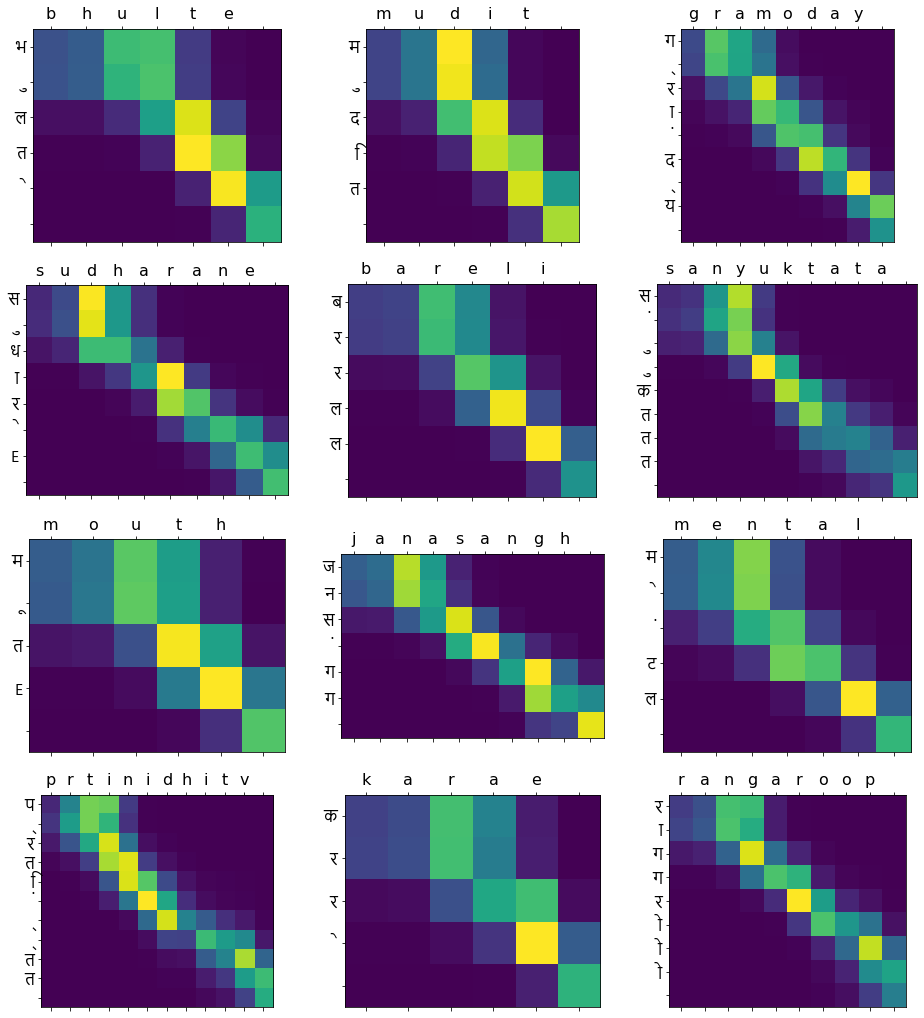

In [ ]:
w_a = model_rnn.attn_plot(inp_val_enc_dt)